In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import torch
import open_clip
import numpy as np
from PIL import Image
from open_clip import SimpleTokenizer
from diffusers import DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPModel

from utils import show_images

### Load additional models: CLIP and CoCa

In [2]:
feature_extractor = CLIPFeatureExtractor.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
clip_model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16
)
coca_model = open_clip.create_model('coca_ViT-L-14', pretrained='laion2B-s13B-b90k').to('cuda')
coca_model.dtype = torch.float16
coca_transform = open_clip.image_transform(
    coca_model.visual.image_size,
    is_train = False,
    mean = getattr(coca_model.visual, 'image_mean', None),
    std = getattr(coca_model.visual, 'image_std', None),
)
coca_tokenizer = SimpleTokenizer()

/home/user/Projects/denk_baseline/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Create DiffusionPipeline from local .py file

In [3]:
mixing_pipeline = DiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    custom_pipeline="../images_mixing.py",
    clip_model=clip_model,
    feature_extractor=feature_extractor,
    coca_model=coca_model,
    coca_tokenizer=coca_tokenizer,
    coca_transform=coca_transform,
    torch_dtype=torch.float16,
)
mixing_pipeline.enable_attention_slicing()
mixing_pipeline = mixing_pipeline.to("cuda")

### Select type of mixing: from style to content or from content to style

#### Each `slerp_` parameter has an impact on both images - style and content (more style - less content and and vice versa)
$content strength = 1.0 - stylestrength$

**slerp_latent_style_strength** - parameter has an impact on start noised latent space. Calculate as spherical distance between latent spaces of style image and content image.  
**slerp_prompt_style_strength** - parameter has an impact on each diffusion iteration as usual prompt and for clip-guided algorithm. Calculate with CLIP text model as spherical distance between clip text embeddings of style prompt and content prompt.  
**slerp_clip_image_style_strength** - parameter has an impact on each diffusion iteration for clip-guided algorithm. Calculate with CLIP image model as spherical distance between clip image embeddings of style image and content image.  
  
**noise_strength** - just noise coefficient. Less noise - more original information from start latent space. Recommended minimum value - 0.5, maximum - 0.7.  

### From style to content recommended start parameters:
```
noise_strength=0.5
slerp_latent_style_strength=0.8
slerp_prompt_style_strength=0.2
slerp_clip_image_style_strength=0.2
```

### From content to style recommended start parameters:
```
noise_strength=0.5
slerp_latent_style_strength=0.2
slerp_prompt_style_strength=0.8
slerp_clip_image_style_strength=0.8
```

### Let's see an example how we can find the best (for my opinion) mixing with approach `from content to style`

#### 0. Load images

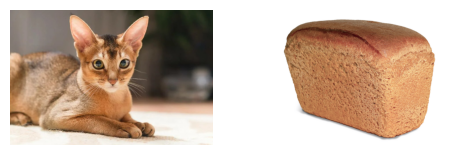

In [4]:
content_image = Image.open('../images/cat.jpeg').convert("RGB")
style_image = Image.open('../images/bread.png').convert("RGB")

show_images([content_image, style_image])

#### 1. Search `noise_strength` parameter in range [0.4, 0.6]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

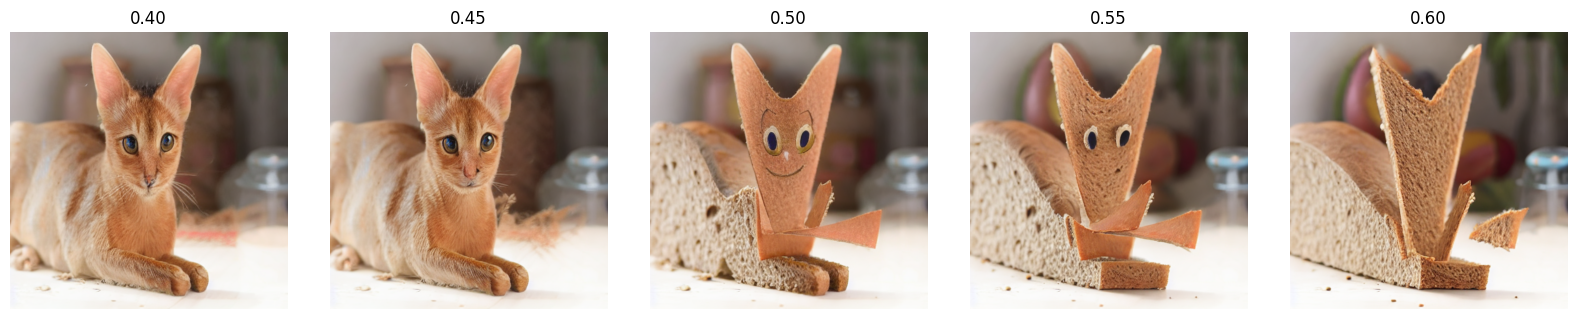

In [5]:
images = []
parameters = []

for parameter in np.arange(0.4, 0.61, 0.05):
    generator = torch.Generator(device="cuda").manual_seed(17) 
    pipe_images = mixing_pipeline(
        num_inference_steps=50,
        content_image=content_image,
        style_image=style_image,
        noise_strength=parameter,
        slerp_latent_style_strength=0.2,
        slerp_prompt_style_strength=0.8,
        slerp_clip_image_style_strength=0.8,
        guidance_scale=9.0,
        batch_size=1,
        clip_guidance_scale=100,
        generator=generator,
    ).images
    
    parameters += [f'{parameter:0.2f}']
    images += pipe_images
    
show_images(images, titles=parameters, figsize=(16, 8))

#### 2. I like image with coef 0.5, so let's fix parameter `noise_strength=0.5` and find `slerp_latent_style_strength` coef

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

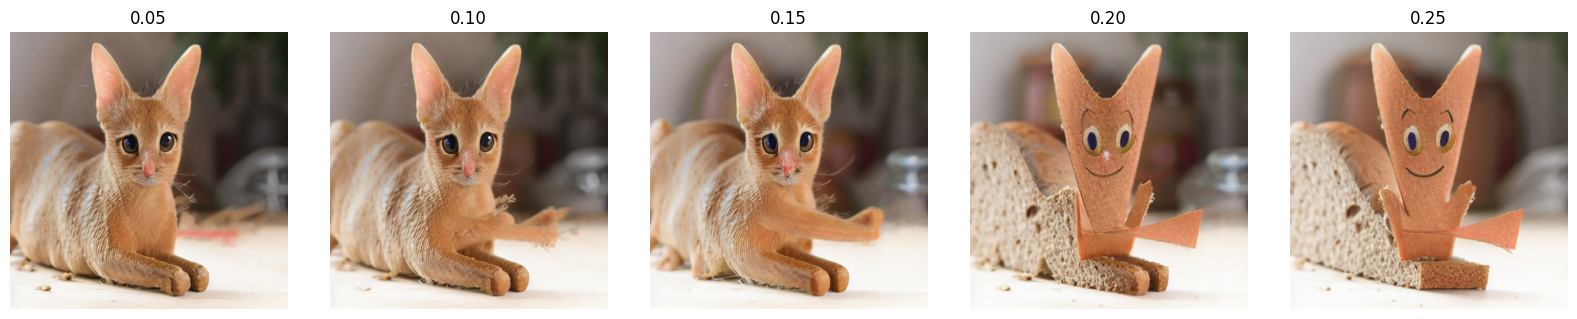

In [6]:
images = []
parameters = []

for parameter in np.arange(0.05, 0.3, 0.05):
    generator = torch.Generator(device="cuda").manual_seed(17) 
    pipe_images = mixing_pipeline(
        num_inference_steps=50,
        content_image=content_image,
        style_image=style_image,
        noise_strength=0.5,
        slerp_latent_style_strength=parameter,
        slerp_prompt_style_strength=0.8,
        slerp_clip_image_style_strength=0.8,
        guidance_scale=9.0,
        batch_size=1,
        clip_guidance_scale=100,
        generator=generator,
    ).images
    
    parameters += [f'{parameter:0.2f}']
    images += pipe_images
    
show_images(images, titles=parameters, figsize=(16, 8))

#### 3. Now I select image with parameter `slerp_latent_style_strength=0.2` and find `slerp_prompt_style_strength`  and `slerp_clip_image_style_strength` with the same coef

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

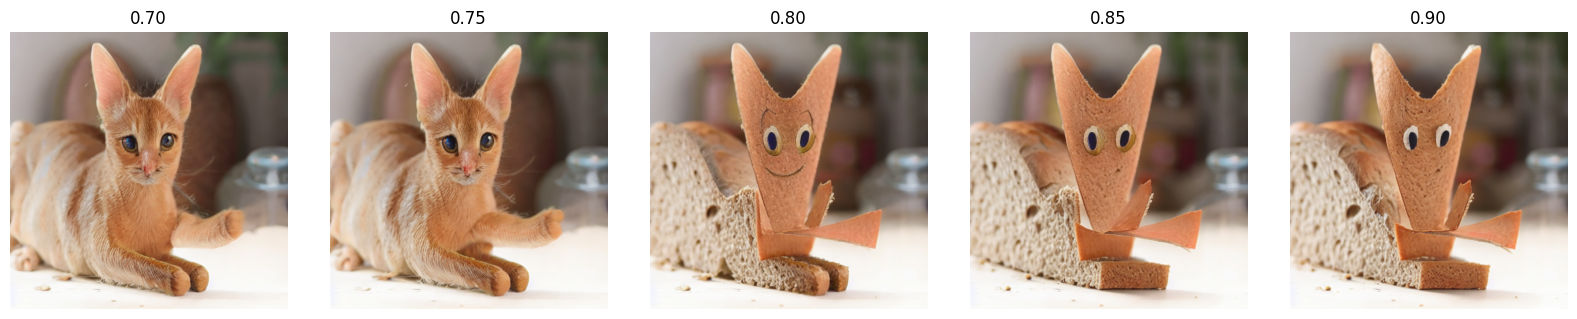

In [7]:
images = []
parameters = []

for parameter in np.arange(0.7, 0.95, 0.05):
    generator = torch.Generator(device="cuda").manual_seed(17) 
    pipe_images = mixing_pipeline(
        num_inference_steps=50,
        content_image=content_image,
        style_image=style_image,
        noise_strength=0.5,
        slerp_latent_style_strength=0.2,
        slerp_prompt_style_strength=parameter,
        slerp_clip_image_style_strength=parameter,
        guidance_scale=9.0,
        batch_size=1,
        clip_guidance_scale=100,
        generator=generator,
    ).images
    
    parameters += [f'{parameter:0.2f}']
    images += pipe_images
    
show_images(images, titles=parameters, figsize=(16, 8))

### Final result

  0%|          | 0/25 [00:00<?, ?it/s]

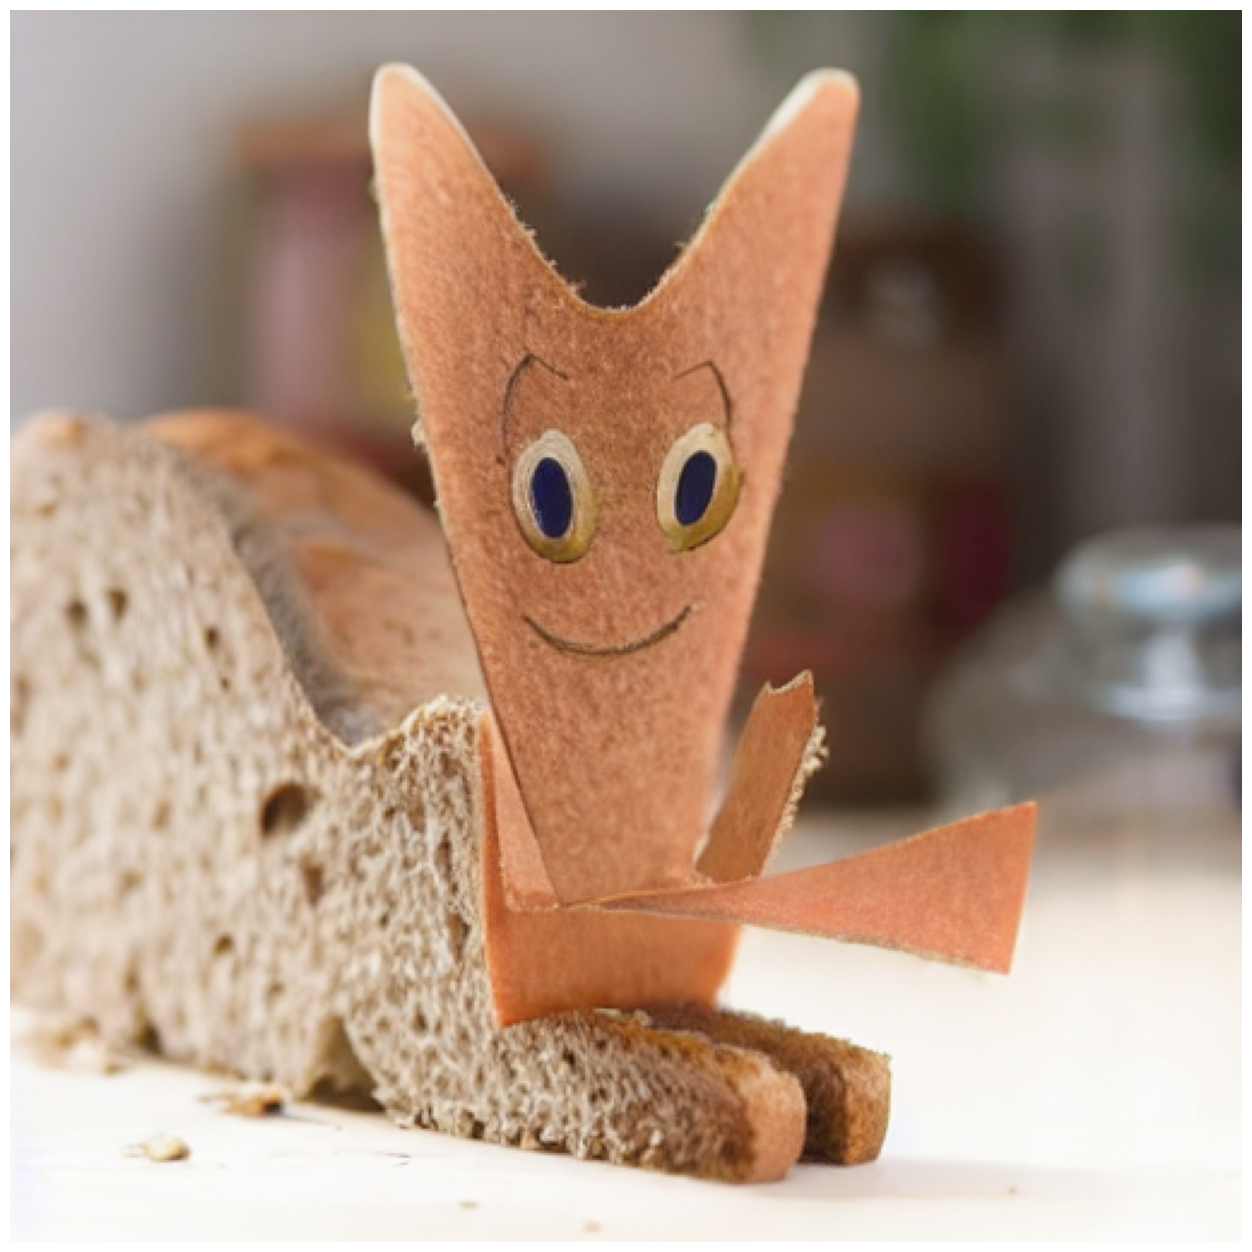

In [8]:
generator = torch.Generator(device="cuda").manual_seed(17) 
pipe_images = mixing_pipeline(
        num_inference_steps=50,
        content_image=content_image,
        style_image=style_image,
        noise_strength=0.5,
        slerp_latent_style_strength=0.2,
        slerp_prompt_style_strength=0.8,
        slerp_clip_image_style_strength=0.8,
        guidance_scale=9.0,
        batch_size=1,
        clip_guidance_scale=100,
        generator=generator,
    ).images

show_images(pipe_images, figsize=(16, 16))